In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
merchandise_info = pd.read_csv('../data/merchandise_info.csv')
wholesale_prices = pd.read_csv('../data/wholesale_price.csv')
sales_history = pd.read_csv('../data/sales_history.csv')

sales_history['date'] = pd.to_datetime(sales_history['date'])
wholesale_prices['date'] = pd.to_datetime(wholesale_prices['date'])

### missing values

In [3]:
print(sales_history.isna().sum())
print(wholesale_prices.isna().sum())

date                0
transaction_time    0
item_ID             0
quantity            0
sales_price         0
sales_type          0
discount            0
dtype: int64
date               0
item_ID            0
wholesale_price    0
dtype: int64


### outliers and anomalies

0.01
0.1
0.003


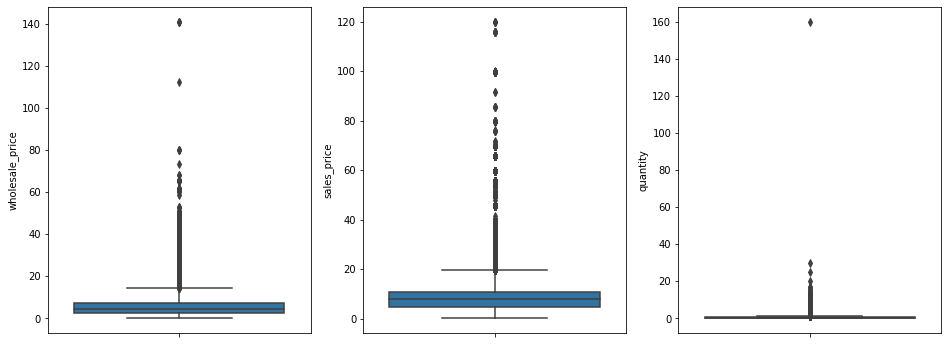

In [5]:
# filter out non-sales data
sales_history = sales_history[sales_history['sales_type']=='Sales']

print(wholesale_prices['wholesale_price'].min())
print(sales_history['sales_price'].min())
print(sales_history['quantity'].min())

fig, ax = plt.subplots(1,3,figsize=(16, 6))
sns.boxplot(y = wholesale_prices['wholesale_price'], ax=ax[0])
sns.boxplot(y = sales_history['sales_price'], ax=ax[1])
sns.boxplot(y = sales_history['quantity'], ax=ax[2])

plt.show()

The outcome shows there is no negative value in prices and quantities, but outliers need to be futher investigated

### replace outliers in price

In [7]:
# replace outliers in wholesale price with the average price of 2 weeks before and after
item_IDs = wholesale_prices['item_ID'].unique()
for item_ID in item_IDs:
    item_df = wholesale_prices[wholesale_prices['item_ID']==item_ID]

    median = item_df['wholesale_price'].median()
    upper_quartile = item_df['wholesale_price'].quantile(0.75)
    lower_quartile = item_df['wholesale_price'].quantile(0.25)
    IQR = upper_quartile - lower_quartile
    
    outlier_idx = item_df[(item_df['wholesale_price'] > upper_quartile + 3*IQR) | (item_df['wholesale_price'] < lower_quartile - 3*IQR) | (item_df['wholesale_price']<0.2)].index

    for idx in outlier_idx:
        d = item_df.loc[idx,'date']
        nearest_idx = item_df[(item_df['date']<= d + pd.DateOffset(14)) & (item_df['date']>= d - pd.DateOffset(14))].index
        normal_nearest_idx = list(set(nearest_idx) - set(outlier_idx))

        if len(normal_nearest_idx) == 0:
            replace_value = median
        else:
            replace_value = item_df.loc[normal_nearest_idx,'wholesale_price'].mean()
        wholesale_prices.loc[idx,'wholesale_price'] = replace_value    

In [6]:
# replace outliers in sale price with the average price of 15 transactions before and after
sales_history = sales_history.sort_values(by=['item_ID','date','transaction_time'])
item_IDs = sales_history['item_ID'].unique()

for item_ID in item_IDs:
    item_df = sales_history[sales_history['item_ID']==item_ID]

    median = item_df['sales_price'].median()
    upper_quartile = item_df['sales_price'].quantile(0.75)
    lower_quartile = item_df['sales_price'].quantile(0.25)
    IQR = upper_quartile - lower_quartile
    
    outlier_idx = item_df[(item_df['sales_price'] > upper_quartile + 3*IQR) | (item_df['sales_price'] < lower_quartile - 3*IQR) | (item_df['sales_price']<=0.5)].index

    for idx in outlier_idx:
        d = item_df.loc[idx,'date']

        nearest_idx = range(idx-15,idx+15, 1)
        normal_nearest_idx = list(set(nearest_idx) - set(outlier_idx))
        normal_nearest_idx = [i for i in normal_nearest_idx if i in item_df.index]

        if len(normal_nearest_idx) == 0:
            replace_value = median
        else:
            replace_value = item_df.loc[normal_nearest_idx,'sales_price'].mean()
        sales_history.loc[idx,'sales_price'] = replace_value

In [9]:
sales_history = sales_history.merge(merchandise_info, on='item_ID', how='left')
sales_history = sales_history.merge(wholesale_prices, on=['date','item_ID'], how='left')
wholesale_prices = wholesale_prices.merge(merchandise_info, on='item_ID', how='left')

In [ ]:
wholesale_prices.to_csv('../data/processed_wholesale_prices.csv',index=False)

### Sale features

In [10]:
# binarize discount
sales_history['discount'] = sales_history['discount'].replace({'Y':1, 'N':0})

# calculate sales profit
sales_history['sales_profit'] = (sales_history['sales_price'] - sales_history['wholesale_price']) * sales_history['quantity']

sales_history['cost'] = sales_history['wholesale_price'] * sales_history['quantity']

sales_history['markup_rate'] = (sales_history['sales_price']-sales_history['wholesale_price']) / sales_history['wholesale_price']

### Time features: date, week, month, season

In [11]:
sales_history['date'] = pd.to_datetime(sales_history['date'])
sales_history['season'] = sales_history['date'].dt.month%12 // 3 + 1 # season divisions: (12,1,2); (3,4,5); (6,7,8); (9,10,11)
sales_history['month'] = sales_history['date'].dt.month
sales_history['day_of_week'] = sales_history['date'].dt.day_of_week + 1 # to make Monday as 1, Sunday as 7

In [12]:
sales_history.drop(columns=['sales_type','item_name_chinese','category_name_chinese'], inplace=True)
sales_history.to_csv('../data/processed_sales_history.csv',index=False)

### Group by date, category

In [13]:
daily_category_sales = sales_history.groupby(by=['date','category_name']).agg({'quantity':'sum', 'sales_profit':'sum', 'cost':'sum'})

daily_category_sales.columns = ['quantity_sum', 'sales_profit_sum', 'cost_sum']

daily_category_sales['avg_profit_rate'] = daily_category_sales['sales_profit_sum'] / daily_category_sales['cost_sum']

daily_category_sales = daily_category_sales.pivot_table(index='date', columns='category_name', values=['quantity_sum','sales_profit_sum','cost_sum','avg_profit_rate'])

#daily_category_sales = daily_category_sales.reset_index()
daily_category_sales.head()

avg_profit_rate                            \
category_name Aquatic Roots and Tubers Cauliflower Chili Peppers   
date                                                               
2020-07-01                    0.569336    0.512327      0.862467   
2020-07-02                    0.627912    0.585764      0.777084   
2020-07-03                    0.428204    0.585385      0.669062   
2020-07-04                    0.557864    0.535154      0.779148   
2020-07-05                    0.845018    0.498382      0.707881   

                                                                    \
category_name Edible Mushrooms Leafy Greens Solanaceous Vegetables   
date                                                                 
2020-07-01            0.603026     0.516393               0.221723   
2020-07-02            0.708050     0.707243               1.161231   
2020-07-03            0.749383     0.670679               0.379125   
2020-07-04            0.669301     0.619105               0.841817   
2020-07-05            0.700236     0.644195               0.654603   

                              cost_sum                            \
category_name Aquatic Roots and Tubers Cauliflower Chili Peppers   
date                                                               
2020-07-01                    44.78568   395.83628     408.05555   
2020-07-02                    32.63124   344.33378     376.85583   
2020-07-03                    53.69892   312.45916     401.82115   
2020-07-04                    76.22823   457.40442     464.50121   
2020-07-05                    21.78298   465.82392     595.02793   

                                ...  quantity_sum                   \
category_name Edible Mushrooms  ... Chili Peppers Edible Mushrooms   
date                            ...                                  
2020-07-01           229.94141  ...        76.715           35.365   
2020-07-02           354.74897  ...        66.064           48.510   
2020-07-03           312.27863  ...        64.253           42.442   
2020-07-04           346.67418  ...        81.282           47.262   
2020-07-05           430.89539  ...        98.496           73.213   

                                                          sales_profit_sum  \
category_name Leafy Greens Solanaceous Vegetables Aquatic Roots and Tubers   
date                                                                         
2020-07-01         205.402                 35.374                 25.49812   
2020-07-02         198.362                 32.199                 20.48956   
2020-07-03         191.779                 35.896                 22.99408   
2020-07-04         236.587                 57.067                 42.52497   
2020-07-05         223.899                 61.816                 18.40702   

                                                                       \
category_name Cauliflower Chili Peppers Edible Mushrooms Leafy Greens   
date                                                                    
2020-07-01      202.79772     351.93465        138.66059    512.10105   
2020-07-02      201.69822     292.84857        251.18003    583.96795   
2020-07-03      182.90884     268.84345        234.01637    564.58894   
2020-07-04      244.78158     361.91539        232.02942    704.10491   
2020-07-05      232.15808     421.20867        301.72841    616.37082   

                                      
category_name Solanaceous Vegetables  
date                                  
2020-07-01                  32.08965  
2020-07-02                  92.46514  
2020-07-03                  53.94768  
2020-07-04                 149.64214  
2020-07-05                 162.74564  

[5 rows x 24 columns]

In [14]:
daily_category_sales.to_csv('../data/daily_category_sales.csv')

# specify header and index column when reading back
# pd.read_csv('../data/daily_category_sales.csv', header=[0,1], index_col=0)

### Group by date, product

In [23]:
daily_item_sales = sales_history.groupby(by=['date','item_ID']).agg({'quantity':'sum', 'sales_profit':'sum', 'cost':'sum'})
daily_item_sales = daily_item_sales.reset_index()
daily_item_sales['avg_profit_rate'] = daily_item_sales['sales_profit'] / daily_item_sales['cost']
daily_item_sales = daily_item_sales.merge(wholesale_prices, on=['date','item_ID'], how='left')
daily_item_sales.drop(columns=['item_name_chinese','category_name_chinese'], inplace=True)

In [24]:
daily_item_sales.to_csv('../data/daily_item_sales.csv',index=False)